# 🖥️ Choosing a timestep and integration method

In Parcels, we can simulate virtual particles through time. Kernels which compute a process as a function of time, such as advection, can do so by numerically integrating the process over each timestep `dt`. In this guide we explore how to control the numerical accuracy of a Parcels simulation by choosing a timestep `dt` and an integration method.

```{note}
This notebook is based on the [workshop on writing custom Kernels](https://github.com/Parcels-code/10year-anniversary-session2/blob/main/advection_and_windage.ipynb) from the 10-year Parcels event.
```

## Timestep

The choice of timestep affects the accuracy and duration of our simulation. The required accuracy of the integration ultimately depends on the desired application of the particle trajectories. In general, we want our timestep to be small enough to smoothly resolve the time-evolving process of interest, and not so small that our simulations take forever. Here, we will first look at how to estimate a priori what an appropriate timestep could be, and then at how to test a Parcels simulation to check the accuracy.

### A priori estimation

In this example, we will estimate the appropriate timestep to compute advection of a virtual particle through an ocean current field. 

Advection, the change in position $\mathbf{x}(t) = (lon(t), lat(t))$ at time $t$, can be described by the equation:

$$
\begin{aligned}
\frac{\text{d}\mathbf{x}(t)}{\text{d}t} = \mathbf{v}(\mathbf{x}(t),t),
\end{aligned}
$$

where $\mathbf{v}(\mathbf{x},t) = (u(\mathbf{x},t), v(\mathbf{x},t))$ describes the ocean velocity field at position $\mathbf{x}$ at time $t$.

To estimate the timescale that we want to resolve, we can think about the scales at which advection varies. Here we use the daily velocity fields at 1/12th degree horizontal resolution from the Copernicus Marine Service. This means that the velocity will vary in time at scales >= 24 hours, and in space at scales >= 1/12th degree.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import parcels

# Load the CopernicusMarine data in the Agulhas region from the example_datasets
example_dataset_folder = parcels.download_example_dataset(
    "CopernicusMarine_data_for_Argo_tutorial"
)

ds_fields = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
ds_fields.load()  # load the dataset into memory

fieldset = parcels.FieldSet.from_copernicusmarine(ds_fields)

# Check field resolution in time and space
print(
    f"dt = {np.unique(np.diff(ds_fields.time.values).astype('timedelta64[h]'))} hours"
)
print(f"dlat = {np.unique(np.diff(ds_fields.latitude.values))} degrees")
print(f"dlon = {np.unique(np.diff(ds_fields.longitude.values))} degrees")

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.
dt = [24] hours
dlat = [0.08333206 0.08333588] degrees
dlon = [0.08332825 0.08334351] degrees


In our Parcels simulation, we must ensure that:
- `dt` < 24 hours
- `particles.dlon`/`particles.dlat` < 1/12th degree. 

We can rewrite the second condition using the scale relation:

$$
\begin{aligned}
\text{d}lon \propto U \text{d}t,
\end{aligned}
$$

to express the condition as a function of `dt`:

$$
\begin{aligned}
U \text{d}t < 1/12 \text{ (degrees lon)}
\end{aligned}
$$

$$
\begin{aligned}
\text{d}t < \frac{1}{12 U}
\end{aligned}
$$

We can use the maximum velocity (in degrees s<sup>-1</sup>) in our flow field as a conservative estimate for $U$:

In [ ]:
# Use the maximum velocity at the surface to scale dlon/dlat
U_max_surface = np.nanmax(np.hypot(ds_fields.uo, ds_fields.vo))
print(f"U_max = {str(np.round(U_max_surface, 2))} m s-1")

# convert to degrees s-1 (at lat = 30 deg S, lon = 31 deg E)
U_max_surface_deg = parcels.GeographicPolar().to_target(U_max_surface,0,-30,31)
print(f"      == {str(np.round(U_max_surface_deg * 1e5, 2))}e-5 degrees s-1")

U_max = 1.65 m s-1
      == 1.71e-5 degrees s-1


```{admonition} 🖥️ Spherical grids and unit converters
:class: seealso
Read the [UnitConversion guide](./tutorial_unitconverters.ipynb) to see how to use `parcels.GeographicPolar()` to convert to degrees s<sup>-1</sup>.
```

Using `U_max_surface_deg`, we find a second estimate of an appropriate `dt`:

$$
\begin{aligned}
\text{d}t < 2 \text{ hours}
\end{aligned}
$$

### Test timesteps

Now that we have an estimate of an appropriate choice for `dt`, we can test a range of values in Parcels to understand the impact on the accuracy of our trajectories. To do so, we can run simulations using `parcels.kernels.AdvectionRK2` for a limited number of particles and quantify the differences.

In [15]:
# Particle locations and initial time
npart = 5  # number of particles to be released
initial_release_lons = 32 * np.ones(npart)
initial_release_lats = np.linspace(-32.5, -32, npart, dtype=np.float32)
initial_release_times = np.repeat(
    ds_fields.time.values[0], npart
)  # release all particles at the start time of the fieldset
initial_release_zs = np.repeat(ds_fields.depth.values[0], npart)

We simulate particles using a range of timesteps that differ by a factor 2-10, starting at (dt < 24 hours). We also keep track of the time it takes to run each simulation:

In [ ]:
import time
runtime = np.timedelta64(7, "D")  # Total simulation time

dt_choices = [
    np.timedelta64(12, "h"),
    np.timedelta64(6, "h"),
    np.timedelta64(1, "h"),
    np.timedelta64(20, "m"),
    np.timedelta64(5, "m"),
]

sim_duration = np.zeros(len(dt_choices))
for i, dt in enumerate(dt_choices):
    pset = parcels.ParticleSet(
        fieldset=fieldset,
        pclass=parcels.Particle,
        time=initial_release_times,
        z=initial_release_zs,
        lat=initial_release_lats,
        lon=initial_release_lons,
    )
    outputdt = dt
    chunks = int(
        runtime / outputdt / 2
    )  # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile

    pfile = parcels.ParticleFile(
        store=f"output/AdvectionRK2_dt_{int(dt / np.timedelta64(1, 's'))}s.zarr",
        outputdt=outputdt,
        chunks=(len(pset), chunks),
    )

    print(
        f"Begin simulation for dt = {int(dt / np.timedelta64(1, 's'))} s"
    )
    # time and run simulation
    start_time = time.time()
    pset.execute(parcels.kernels.AdvectionRK2, runtime=runtime, dt=dt, output_file=pfile)
    sim_duration_i = time.time()-start_time
    sim_duration[i] = sim_duration_i

Begin simulation for dt = 43200 s
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionRK2_dt_43200s.zarr
Integration time: 2024-01-07T12:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 5725055.99it/s]
Begin simulation for dt = 21600 s
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionRK2_dt_21600s.zarr
Integration time: 2024-01-07T18:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 1651223.40it/s]
Begin simulation for dt = 3600 s
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionRK2_dt_3600s.zarr
Integration time: 2024-01-07T23:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 645401.49it/s]
Begin simulation for dt = 1200 s
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/outpu

Let's start by comparing the trajectories of the different simulations:

In [31]:
# To compare the results visually, we will need distinct colour maps for each timestep
dt_colours = np.linspace(0, 1, len(dt_choices), endpoint=True)

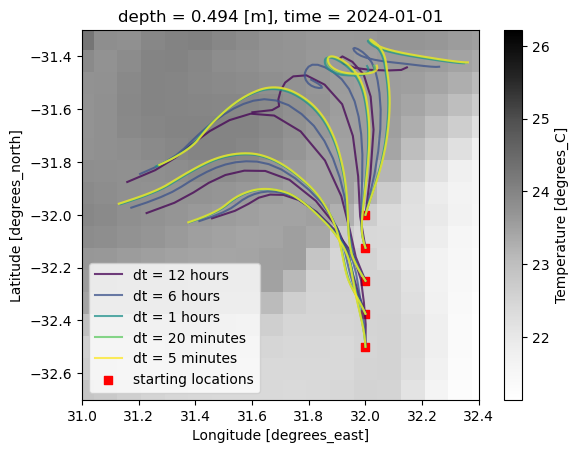

In [ ]:
fig = plt.figure()
ax = plt.axes()
# ax.set_xlabel("Longitude")
temperature = ds_fields.isel(time=0, depth=0).thetao.plot(cmap="Greys")
for j, dt in enumerate(dt_choices):
    ds = xr.open_zarr(
        f"output/AdvectionRK2_dt_{int(dt / np.timedelta64(1, 's'))}s.zarr"
    )
    labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)
    ax.plot(
        ds.lon.T,
        ds.lat.T,
        alpha=0.75,
        color=plt.cm.viridis(dt_colours[j]),
        label=labels,
    )
ax.scatter(ds.lon[:,0],ds.lat[:,0],c="r",marker="s",label="starting locations")
ax.legend()
ax.set_ylim(-32.7,-31.3)
ax.set_xlim(31,32.4)
plt.show()

We see that as the timestep becomes smaller, the trajectories start to converge. As expected from our horizontal grid scaling, the 2 simulations with `dt` > 2 hours produce trajectories that end up in different grid cells. The other three simulations (`dt` = (1 h, 20 min, 5 min)) are more difficult to separate visually. 

To quantify the precision of these simulations, we can compute the separation distance between the trajectories with the same starting location. Since we have no exact solution to these trajectories, we use our highest resolution simulation as a benchmark. The separation distance is a common metric to analyse particle trajectories, as described in [the Lagrangian Diagnostics project](https://lagrangian-diags.readthedocs.io/en/latest/tutorials/absolute_distance_method01.html).

In [42]:
def dist_km(lona, lonb, lata, latb):
    """
    Function to calculate the distance between 2 points in km
    Haversine formula used, which assumes the Earth is a sphere.
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    """

    R = 6371.0  # approximate radius of earth in km

    lat1 = np.radians(lata)
    lon1 = np.radians(lona)
    lat2 = np.radians(latb)
    lon2 = np.radians(lonb)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.square(np.sin(dlat / 2)) + np.cos(lat1) * np.cos(lat2) * np.square(
        np.sin(dlon / 2)
    )
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

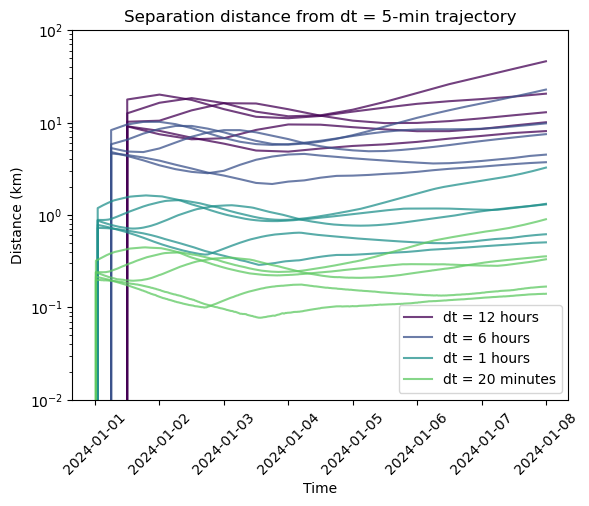

In [47]:
dist_end = np.zeros((len(dt_choices) - 1, npart))

fig=plt.figure()
ax=plt.axes()
ax.set_title("Separation distance from dt = 5-min trajectory")
ax.set_xlabel("Time")
ax.tick_params("x", rotation=45)
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e2)

# set 5 minute dt as benchmark
ds_5min = xr.open_zarr(f"output/AdvectionRK2_dt_300s.zarr")
for i, dt in enumerate(dt_choices[:-1]):
    ds = xr.open_zarr(
        f"output/AdvectionRK2_dt_{int(dt / np.timedelta64(1, 's'))}s.zarr"
    )
    labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)

    # subset 5 minute data to match dt
    lon_5min_sub = ds_5min.lon.where(
        ds_5min.time.isin(ds.time.values).compute(), drop=True
    ).values
    lat_5min_sub = ds_5min.lat.where(
        ds_5min.time.isin(ds.time.values).compute(), drop=True
    ).values

    # remove nans
    lon_valid = ds.lon.where(~np.isnan(ds.lon).compute(), drop=True).values
    lat_valid = ds.lat.where(~np.isnan(ds.lat).compute(), drop=True).values

    # compute separation distance between each particle in km
    dist = dist_km(lon_valid, lon_5min_sub, lat_valid, lat_5min_sub)

    # plot
    time_valid = ds.time.where(~np.isnan(ds.time).compute(), drop=True)
    ax.plot(
        time_valid.T,
        dist.T,
        alpha=0.75,
        color=plt.cm.viridis(dt_colours[i]),
        label=labels,
    )
    dist_end[i] = dist[:, -1]
ax.legend()
ax.set_ylabel("Distance (km)")
plt.show()

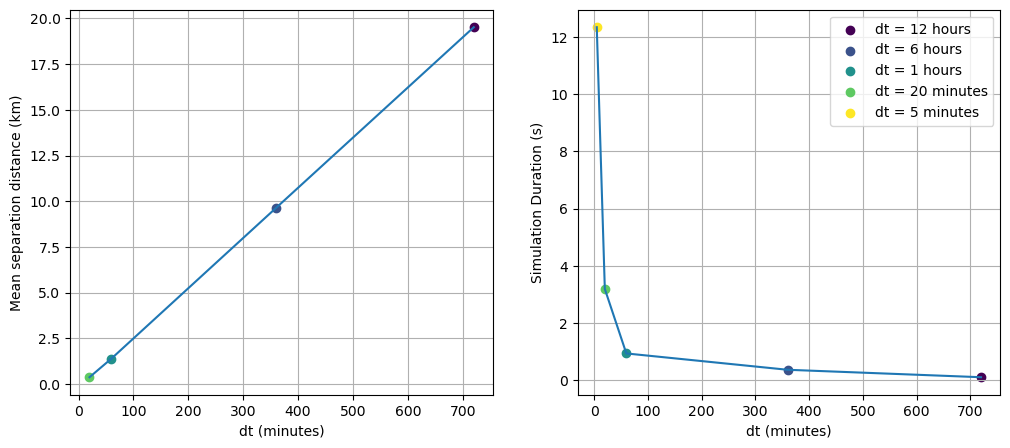

dt choices = [720 360  60  20   5] minutes
precision = [19.52  9.64  1.4   0.38] km
sim duration = [ 0.11  0.37  0.94  3.19 12.34] s


In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for i, dt in enumerate(dt_choices[:-1]):
    ax[0].scatter(
        (dt / np.timedelta64(1, "m")).astype(int),
        np.mean(dist_end[i]),
        color=plt.cm.viridis(dt_colours[i]),
        label=f"dt = {str(dt)}"
    )
ax[0].plot(
    (dt_choices[:-1] / np.timedelta64(1, "m")).astype(int),
    np.mean(dist_end,axis=1)
)

ax[0].set_ylabel("Mean separation distance (km)")
ax[0].set_xlabel("dt (minutes)")
ax[0].grid()
ax[1].plot(dt_choices,sim_duration)
for i, dt in enumerate(dt_choices):
    ax[1].scatter(
        (dt / np.timedelta64(1, "m")).astype(int),
        sim_duration[i],
        color=plt.cm.viridis(dt_colours[i]),
        label=f"dt = {str(dt)}"
    )
ax[1].set_ylabel("Simulation Duration (s)")
ax[1].set_xlabel("dt (minutes)")
ax[1].grid()
ax[1].legend()
plt.show()
print(f"dt choices = {(dt_choices / np.timedelta64(1, "m")).astype(int)} minutes")
print(f"precision = {np.round(np.mean(dist_end,axis=1),2)} km")
print(f"sim duration = {np.round(sim_duration,2)} s")

We can see that in our simulation advecting particles for 7 days, the effect of `dt` on the precision of our simulation is approximately linear. The precision for a simulation with a timestep of 20 minutes is order of magnitude ~100 m. The effect on the time it takes to run a simulation is not linear in our case however; it increases sharply as we decrease our timestep. This may be optimized using more efficient chunking.

| `dt`       | Mean separation distance after 7 days (km) | Simulation duration (s)  | 
| ---------- | ------------------------------------------ | ------------------------ |
| 12 hours   | 19.52                                      | 0.11                     |
| 6 hours    | 9.64                                       | 0.37                     | 
| 1 hour     | 1.4                                        | 0.94                     | 
| 20 minutes | 0.38                                       | 3.19                     | 
| 5 minutes  | x                                          | 12.34                    | 


```{note}
The desired precision is not always best measured by the separation distance of individual trajectories. Depending on the application of your Parcels simulation and the process you are computing, other metrics may be more suitable.
```

## Integration schemes

Parcels comes with a number of built-in advection Kernels. These kernels integrate the virtual particles' position in time as a function of a velocity field, as described in the [Parcels workflow explanation of kernels](../../getting_started/explanation_concepts.md#3-kernels). 

In [ ]:
advection_schemes = [
    parcels.kernels.AdvectionEE,
    parcels.kernels.AdvectionRK2,
    parcels.kernels.AdvectionRK4,
]

In [ ]:
# Now let's compare different advection schemes with the same timestep
fig, axs = plt.subplots(nrows=1, ncols=len(dt_choices), figsize=(20, 5))
for i, dt in enumerate(dt_choices):
    axs[i].set_title(f"{str(dt)}")
    axs[i].set_xlabel("Longitude")
    for j, advection_scheme in enumerate(advection_schemes):
        ds = xr.open_zarr(
            f"output/{advection_scheme.__name__}_dt_{int(dt / np.timedelta64(1, 's'))}s.zarr"
        )
        labels = [f"{advection_scheme.__name__}"] + [None] * (ds.lon.shape[0] - 1)
        axs[i].plot(
            ds.lon.T,
            ds.lat.T,
            alpha=0.75,
            color=plt.cm.viridis(scheme_colours[j]),
            label=labels,
        )
    axs[0].legend()
    axs[0].set_ylabel("Latitude")
plt.show()

### Accuracy
Compare with AdvectionRK4. Lagrangian Diagnostics. Great Circle Distance. 

Integration scheme = O(1) error -> Finite Size Lyapunov Exponent takes over.

In [ ]:
dist_end = np.zeros((len(advection_schemes) - 1, len(dt_choices), npart))
# Now let's compare different advection schemes with the same timestep
fig, axs = plt.subplots(nrows=1, ncols=len(dt_choices), figsize=(20, 5))
for i, dt in enumerate(dt_choices):
    axs[i].set_title(f"dt = {str(dt)}")
    axs[i].set_xlabel("Time")
    axs[i].tick_params("x", rotation=45)
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e-4, 1e1)
    ds_RK4 = xr.open_zarr(
        f"output/AdvectionRK4_dt_{int(dt / np.timedelta64(1, 's'))}s.zarr"
    )
    for j, advection_scheme in enumerate(advection_schemes[:-1]):
        ds = xr.open_zarr(
            f"output/{advection_scheme.__name__}_dt_{int(dt / np.timedelta64(1, 's'))}s.zarr"
        )
        labels = [f"|{advection_scheme.__name__} - AdvectionRK4|"] + [None] * (
            ds.lon.shape[0] - 1
        )

        # remove nans
        lon_valid_RK4 = ds_RK4.lon.where(
            ~np.isnan(ds_RK4.lon).compute(), drop=True
        ).values
        lat_valid_RK4 = ds_RK4.lat.where(
            ~np.isnan(ds_RK4.lat).compute(), drop=True
        ).values
        lon_valid = ds.lon.where(~np.isnan(ds.lon).compute(), drop=True).values
        lat_valid = ds.lat.where(~np.isnan(ds.lat).compute(), drop=True).values
        dist = dist_km(lon_valid, lon_valid_RK4, lat_valid, lat_valid_RK4)
        time_valid = ds.time.where(~np.isnan(ds.time).compute(), drop=True).values
        axs[i].plot(
            time_valid.T,
            dist.T,
            alpha=0.75,
            color=plt.cm.viridis(scheme_colours[j]),
            label=labels,
        )
        dist_end[j, i] = dist[:, -1]
    axs[i].grid()
    axs[0].legend()
    axs[0].set_ylabel("Distance (km)")
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(
    (dt_choices / np.timedelta64(1, "m")).astype(int),
    np.nanmean(dist_end[0], axis=1),
    "-o",
    color=plt.cm.viridis(scheme_colours[0]),
    label="AdvectionEE - AdvectionRK4",
)
ax.plot(
    (dt_choices / np.timedelta64(1, "m")).astype(int),
    np.nanmean(dist_end[1], axis=1),
    "-o",
    color=plt.cm.viridis(scheme_colours[1]),
    label="AdvectionRK2 - AdvectionRK4",
)
ax.set_ylabel("Mean separation distance (km)")
ax.set_yscale("log")
ax.set_xlabel("dt (minutes)")
ax.legend()
ax.grid()
plt.show()

#### Drifter pair separation: flow conditions
The limitation to numerical accuracy of the integration introduces a positional difference of a certain order of magnitude ($\delta$), as seen in the figures above. After this initial deviation, the time evolution of the separation distance is a feature of the specific flow field. As with the [Lorenz equations](), two initially close particles often separate over time. The rate of separation from a finite perturbation ($\delta$) can be characterized by the _Finite Size Lyapunov Exponent_: DEFINE

We can see that the separation distance of particles with their more accurate counterparts does not keep growing (stochastically) in time, but follows a rather specific time-evolution, as the particles enter different flow conditions. The final accuracy of your simulation may therefore strongly depend on your flow conditions and runtime.